#### Imports, file loading, and function definitions

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [29]:
pd.options.display.max_columns = 100 
pd.options.display.max_rows = 300 

In [30]:
fileName = 'PLL Stats Master - Player Game Logs.csv'
playerdata = pd.read_csv(fileName)
playerdata = playerdata[0:3770]

fileName2 = 'PLL Stats Master - Team Game Logs.csv'
teamdata = pd.read_csv(fileName2)
teamdata = teamdata[teamdata['Season'] != 2022]

In [162]:
def plotter(pred , true):

    plt.plot(true , c = 'blue', label = 'True')
    plt.plot(pred, c = 'orange', label = 'Predicted', linestyle = "--")
    plt.ylim([0,30])
    plt.xlabel('Games')
    plt.ylabel('Goals')
    plt.legend()
    plt.xticks(ticks = [],labels = [])
    plt.savefig('archersplot.jpg')
    plt.show()

In [127]:
def generate (count, mini , maxi, average):
    arr = []
    diff = 1
    while len(arr) < count-1:
        if mini <= average - diff and average + diff <= maxi:
            arr.append(average - diff)
            arr.append(average + diff)
            diff += 1
        else:
            arr.append(average)
            diff = 1
    if len(arr) < count:
        arr.append(average)
    return arr


def replace(data , metric , avg):
    data = data
    length = len(data)
    league = data.describe()
    
    mi1 = league[[metric]][3:4]
    mi = mi1[metric][0] 
    
    ma1 = league[[metric]][7:8] 
    ma = ma1[metric][0]
    
    avg = avg
    
    data.drop(columns = [metric])
    
    new = generate(length , mi , ma , avg )
    
    data[metric] = new
    
    return data
    

def project(initial, metric1 , avg1 , metric2, avg2, metric3 , avg3):
    
    t1 = replace(initial , metric1 , avg1)
    t2 = replace(t1 , metric2 , avg2)
    t3 = replace(t2, metric3 , avg3)
    
    t3 = t3.drop(columns = ['Season' , 'Week' , 'Game' , 'Team' , 'Opponent'])
    t3 = t3[['Shots','Shot%','Efficiency','Possession %',
          'Settled Goal','FB Goals','Assisted Goals','Shot Quality Ratio', 
          'D Efficiency','Turnovers', 'Score Against',
          'Expected Goals','Avg Shot Dist','Margin'
          ,'Settled Goals agaisnt' , 'Save %']]
    
    t4 = imp.fit_transform(t3)
    t4 = stdscaler.fit_transform(t4)
    
    
    preds = model.predict(t4)
    
    t3['predictions'] = preds
    
    
    return t3['predictions'].sum()

def projectfinal(initial, metric1 , avg1 , metric2, avg2, metric3 , avg3):
    
    t1 = replace(initial , metric1 , avg1)
    t2 = replace(t1 , metric2 , avg2)
    t3 = replace(t2, metric3 , avg3)
    
    t3 = t3.drop(columns = ['Season' , 'Week' , 'Game' , 'Team' , 'Opponent'])
    t3 = t3[['Shots','Shot%','Efficiency','Possession %',
          'Settled Goal','FB Goals','Assisted Goals','Shot Quality Ratio', 
          'D Efficiency','Turnovers', 'Score Against',
          'Expected Goals','Avg Shot Dist','Margin'
          ,'Settled Goals agaisnt' , 'Save %']]
    
    t4 = imp.fit_transform(t3)
    t4 = stdscaler.fit_transform(t4)
    
    
    preds = model.predict(t4)
    
    t3['predictions'] = preds
    
    
    return t3

### Prep for Training

In [33]:
#from sklearn.impute import SimpleImputer
teamdata['Avg Shot Dist'] = teamdata['Average Shot Distance'].replace('#DIV/0!' , 10.265)

In [34]:
teamdata['Avg Shot Dist'] = teamdata['Avg Shot Dist'].astype(float)

In [35]:
team = teamdata[['Season','Week','Game','Team','Opponent', 
                 'Shots','Goals','Efficiency', 
                 'Possession %',
                 'Settled Goal','FB Goals','Assisted Goals','Shot Quality Ratio', 
                 'D Efficiency','Turnovers', 'Score Against',
                 'Expected Goals','Avg Shot Dist','Margin', 'Settled Goals agaisnt',
                 'Score','Result', 'Save %']]
team['Shot%'] = team['Goals'] / team['Shots']
team['W/L'] = pd.get_dummies(team.loc[:,'Result'])[['W']]
#team.head()

<ipython-input-35-cfd1bdf67829>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team['Shot%'] = team['Goals'] / team['Shots']
<ipython-input-35-cfd1bdf67829>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team['W/L'] = pd.get_dummies(team.loc[:,'Result'])[['W']]


In [36]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values = np.nan, strategy ='mean')

In [37]:
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()

from sklearn.model_selection import train_test_split
x = team[['Shots','Shot%','Efficiency','Possession %',
                 'Settled Goal','FB Goals','Assisted Goals','Shot Quality Ratio', 
                 'D Efficiency','Turnovers', 'Score Against',
                 'Expected Goals','Avg Shot Dist','Margin', 'Save %' , 'Settled Goals agaisnt']]

x = imp.fit_transform(x)


ylinear = np.array(team[['Score']]).ravel()
ylog = team[['W/L']]

In [38]:
x1 = stdscaler.fit_transform(x)
x_train, x_test, y_train , y_test = train_test_split(x1,ylinear, test_size = .2, random_state = 42)

x_valid, x_train1 = x_train[:15] , x_train[15:]
y_valid, y_train1 = y_train[:15] , y_train[15:]

In [39]:
model = keras.models.Sequential([keras.layers.Dense(50 , activation = 'relu' , input_shape = x_train1.shape[1:]),
                                keras.layers.Dense(100 , activation = 'relu'),
                                keras.layers.Dense(100 , activation = 'relu'),
                                keras.layers.Dense(125 , activation = 'relu'),
                                keras.layers.Dense(100 , activation = 'relu'),
                                keras.layers.Dense(1)])

In [40]:
model.compile(loss = 'mean_squared_error' , 
             optimizer = keras.optimizers.SGD(learning_rate = .01, clipnorm = 1) ,)

In [41]:
history = model.fit(x_train1, y_train1, epochs = 200,
                  validation_data = (x_valid , y_valid))

Epoch 1/200
5/5 [==============================] - 1s 72ms/step - loss: 145.8190 - val_loss: 128.5851
Epoch 2/200
5/5 [==============================] - 0s 13ms/step - loss: 138.0233 - val_loss: 120.7036
Epoch 3/200
5/5 [==============================] - 0s 14ms/step - loss: 129.0219 - val_loss: 110.9132
Epoch 4/200
5/5 [==============================] - 0s 11ms/step - loss: 117.6981 - val_loss: 98.9626
Epoch 5/200
5/5 [==============================] - 0s 13ms/step - loss: 104.1866 - val_loss: 84.9563
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 88.7270 - val_loss: 69.2519
Epoch 7/200
5/5 [==============================] - 0s 13ms/step - loss: 71.5715 - val_loss: 52.5747
Epoch 8/200
5/5 [==============================] - 0s 14ms/step - loss: 52.8568 - val_loss: 35.9538
Epoch 9/200
5/5 [==============================] - 0s 13ms/step - loss: 35.1512 - val_loss: 21.3134
Epoch 10/200
5/5 [==============================] - 0s 11ms/step - loss: 20.6321 - val_loss:

5/5 [==============================] - 0s 16ms/step - loss: 0.0909 - val_loss: 1.1565
Epoch 166/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1340 - val_loss: 1.1669
Epoch 167/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1447 - val_loss: 1.1314
Epoch 168/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1248 - val_loss: 1.1770
Epoch 169/200
5/5 [==============================] - 0s 10ms/step - loss: 0.1329 - val_loss: 1.1484
Epoch 170/200
5/5 [==============================] - 0s 10ms/step - loss: 0.1263 - val_loss: 1.1733
Epoch 171/200
5/5 [==============================] - 0s 10ms/step - loss: 0.1107 - val_loss: 1.1132
Epoch 172/200
5/5 [==============================] - 0s 10ms/step - loss: 0.1177 - val_loss: 1.1834
Epoch 173/200
5/5 [==============================] - 0s 10ms/step - loss: 0.1189 - val_loss: 1.1002
Epoch 174/200
5/5 [==============================] - 0s 10ms/step - loss: 0.1112 - val_loss: 1.2110
Epoch 175/200


### Scoring

#### Training Data Score + Plot

In [42]:
mse_training = model.evaluate(x_train1 , y_train1)
y_pred = model.predict(x_train1)

5/5 [==============================] - 0s 2ms/step


#### Testing Data Score + Plot

In [44]:
y_final = model.predict(x_test)

2/2 [==============================] - 0s 4ms/step


In [45]:
y_test = y_test.reshape(40,1)
test_mse = model.evaluate(x_test, y_test)
test_mse

2/2 [==============================] - 0s 4ms/step - loss: 1.2671


1.2671000957489014

### Now Tweaking Stats for Season Wide Predictions in the 2022 Season

In [47]:
fileName2 = 'PLL Stats Master - Team Game Logs.csv'
teamdata2 = pd.read_csv(fileName2)
teamdata2 = teamdata2[teamdata2['Season'] == 2022]

In [48]:
teamdata2['Avg Shot Dist'] = teamdata2['Average Shot Distance'].replace('#DIV/0!' , 10.265)
teamdata2['Avg Shot Dist'] = teamdata2['Avg Shot Dist'].astype(float)

team2022 = teamdata2[['Season','Week','Game','Team','Opponent', 
                 'Shots','Goals','Efficiency', 
                 'Possession %',
                 'Settled Goal','FB Goals','Assisted Goals','Shot Quality Ratio', 
                 'D Efficiency','Turnovers', 'Score Against',
                 'Expected Goals','Avg Shot Dist','Margin',
                  'Settled Goals agaisnt' , 'Save %',
                 'Score','Result']]

team2022['Shot%'] = team2022['Goals'] / team2022['Shots']
team2022['W/L'] = pd.get_dummies(team2022.loc[:,'Result'])[['W']]

<ipython-input-48-7f5c934f4de4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team2022['Shot%'] = team2022['Goals'] / team2022['Shots']
<ipython-input-48-7f5c934f4de4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team2022['W/L'] = pd.get_dummies(team2022.loc[:,'Result'])[['W']]


In [58]:
archers = team2022[team2022['Team'] == 'Archers']
whipsnakes = team2022[team2022['Team'] == 'Whipsnakes']
waterdogs = team2022[team2022['Team'] == 'Waterdogs']

In [63]:
archers.describe()

,Season,Week,Game,Shots,Goals,Efficiency,Possession %,Settled Goal,FB Goals,Assisted Goals,Shot Quality Ratio,D Efficiency,Turnovers,Score Against,Expected Goals,Avg Shot Dist,Margin,Settled Goals agaisnt,Save %,Score,Shot%,W/L
count,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.00000,12.000000,12.000000
mean,2022.0,7.083333,24.833333,37.750000,11.916667,0.320833,0.484167,7.833333,2.583333,6.916667,2.016667,0.260000,13.500000,10.583333,12.741667,10.292910,1.916667,6.916667,0.525000,12.50000,0.316763,0.583333
std,0.0,4.055486,14.490331,5.029459,3.776924,0.080843,0.034234,1.992410,2.108784,2.843120,0.705605,0.030151,3.343923,2.020726,1.431756,0.499792,4.399552,2.429303,0.086603,4.05642,0.090395,0.514929
min,2022.0,1.000000,4.000000,30.000000,7.000000,0.200000,0.420000,4.000000,0.000000,2.000000,1.100000,0.220000,7.000000,8.000000,10.700000,9.359275,-5.000000,1.000000,0.300000,7.00000,0.170732,0.000000
25%,2022.0,3.750000,14.750000,34.000000,9.000000,0.267500,0.467500,6.750000,1.000000,5.500000,1.675000,0.237500,12.000000,9.000000,11.900000,10.186769,-1.250000,6.500000,0.500000,9.75000,0.256960,0.000000
50%,2022.0,7.500000,24.000000,37.500000,10.000000,0.305000,0.490000,8.000000,2.500000,7.000000,1.850000,0.265000,14.000000,10.500000,12.600000,10.321234,2.000000,7.000000,0.500000,11.00000,0.306250,1.000000
75%,2022.0,10.250000,35.750000,41.000000,15.000000,0.355000,0.492500,9.250000,4.000000,8.000000,2.200000,0.277500,15.250000,12.000000,13.675000,10.521588,5.000000,8.000000,0.600000,16.25000,0.373227,1.000000
max,2022.0,13.000000,47.000000,47.000000,19.000000,0.490000,0.560000,10.000000,6.000000,12.000000,3.600000,0.300000,19.000000,14.000000,15.400000,11.282101,11.000000,10.000000,0.600000,20.00000,0.463415,1.000000


In [122]:
whipsnakes['Shot Quality Ratio'].mean()

1.936363636363636

In [62]:
waterdogs['Goals'].sum()

142

In [61]:
archers['Goals'].sum()

143

#### Manipulating Possession Share

In [104]:
lists = [
        [0.45, 2.01 , 7.8],
        [0.48, 2.01 , 7.8],
        [0.50, 2.01 , 7.8],
        [0.51, 2.01 , 7.8],
        [0.52, 2.01 , 7.8],
        [0.53, 2.01 , 7.8],
        [0.54, 2.01 , 7.8],
        [0.55, 2.01 , 7.8],
        [0.56, 2.01 , 7.8],
        [0.57, 2.01 , 7.8],
        [0.58, 2.01 , 7.8]]
index = pd.DataFrame(lists, columns = ['poss', 'sqr' , 'sg'])

run = [0,1,2,3,4,5,6,7,8,9,10]

result = list()
for i in run:
    w = project(archers , 'Possession %' , index['poss'][i] , 'Shot Quality Ratio', index['sqr'][i] , 'Settled Goal' , index['sg'][i])
    result.append(w)

1/1 [==============================] - 0s 27ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 24ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 28ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 26ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 24ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 25ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 26ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 29ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 28ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 24ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 25ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [112]:
index['Prediction'] = result
index

,poss,sqr,sg,Prediction
0,0.45,2.01,7.8,147.814194
1,0.48,2.01,7.8,151.190857
2,0.50,2.01,7.8,147.814194
3,0.51,2.01,7.8,146.781555
4,0.52,2.01,7.8,146.781555
5,0.53,2.01,7.8,151.190857
6,0.54,2.01,7.8,147.814194
7,0.55,2.01,7.8,146.781555
8,0.56,2.01,7.8,151.190857
9,0.57,2.01,7.8,151.190857


In [110]:
def deepplot(index , x , title):
    
    fig, ax = plt.subplots()


    x = index[x]
    y = index['Prediction']

    ax.plot(x,y, c = 'black')


    ax.set_title(title)
    ax.set_xlabel('Possession Share')
    ax.set_ylabel('Prediction')
    
    
    plt.ylim([140, 160])
    plt.xlim([x.min(),x.max()])

    plt.show()

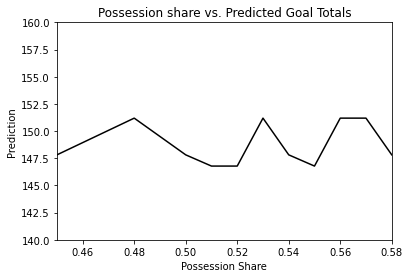

In [111]:
deepplot(index , 'poss' , 'Possession share vs. Predicted Goal Totals')

#### Possession Share Summary 

- After 53% possession we stop seeing real improvement
- That is okay, because 53% possession per game is a realistic goal, whereas 55% + is a much more difficult ask than the already difficult 53%.
- We essentially see no gain (other metrics constant) in predicted goals past, 53% possession, so we will hold that constant in the next round of projections
- A logical assumption would be that now that this team has the ball more, they will score more settled goals with that time, so we will manipulate settled goals next.

#### Manipulating Settled Goals

In [115]:
lists = [
        [0.53, 2.01 , 7.8],
        [0.53, 2.01 , 7.9],
        [0.53, 2.01 , 8.0],
        [0.53, 2.01 , 8.1],
        [0.53, 2.01 , 8.2],
        [0.53, 2.01 , 8.3],
        [0.53, 2.01 , 8.4],
        [0.53, 2.01 , 8.5],
        [0.53, 2.01 , 8.6],
        [0.53, 2.01 , 8.7],
        [0.53, 2.01 , 8.8]]
index = pd.DataFrame(lists, columns = ['poss', 'sqr' , 'sg'])

run = [0,1,2,3,4,5,6,7,8,9,10]

result = list()
for i in run:
    w = project(archers , 'Possession %' , index['poss'][i] , 'Shot Quality Ratio', index['sqr'][i] , 'Settled Goal' , index['sg'][i])
    result.append(w)

1/1 [==============================] - 0s 25ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 24ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 26ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 24ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 24ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 24ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 36ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 27ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 26ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 25ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 29ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [116]:
index['Prediction'] = result
index

,poss,sqr,sg,Prediction
0,0.53,2.01,7.8,151.190857
1,0.53,2.01,7.9,147.866028
2,0.53,2.01,8.0,151.190857
3,0.53,2.01,8.1,154.970108
4,0.53,2.01,8.2,147.866028
5,0.53,2.01,8.3,154.970108
6,0.53,2.01,8.4,147.866028
7,0.53,2.01,8.5,151.190857
8,0.53,2.01,8.6,154.970108
9,0.53,2.01,8.7,147.866028


In [117]:
def deepplot(index , x , title):
    
    fig, ax = plt.subplots()


    x = index[x]
    y = index['Prediction']

    ax.plot(x,y, c = 'black')


    ax.set_title(title)
    ax.set_xlabel('Settled Goals')
    ax.set_ylabel('Prediction')
    
    
    plt.ylim([140, 160])
    plt.xlim([x.min(),x.max()])

    plt.show()

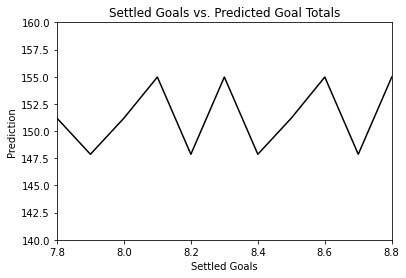

In [118]:
deepplot(index , 'sg' , 'Settled Goals vs. Predicted Goal Totals')

#### Settled Goals Summary

- This is a goal metric, so we want to be conservative while manipulating it.
- Noticeable improvement stops once settled goals is at 8.3 per game. That is a realistic improvement over the 7.8 that the archers were getting with 48% posession per game
- We will use 8.3 going forward

#### Manipulating Shot Quality Ratio

In [123]:
lists = [
        [0.53, 1.50 , 8.3],
        [0.53, 1.60 , 8.3],
        [0.53, 1.70 , 8.3],
        [0.53, 1.80 , 8.3],
        [0.53, 1.90 , 8.3],
        [0.53, 2.00 , 8.3],
        [0.53, 2.10 , 8.3],
        [0.53, 2.20 , 8.3],
        [0.53, 2.25 , 8.3],
        [0.53, 2.30 , 8.3],
        [0.53, 2.40 , 8.3]]
index = pd.DataFrame(lists, columns = ['poss', 'sqr' , 'sg'])

run = [0,1,2,3,4,5,6,7,8,9,10]

result = list()
for i in run:
    w = project(archers , 'Possession %' , index['poss'][i] , 'Shot Quality Ratio', index['sqr'][i] , 'Settled Goal' , index['sg'][i])
    result.append(w)

1/1 [==============================] - 0s 40ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 25ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 25ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 41ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 43ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 25ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 25ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 25ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 26ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 26ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

1/1 [==============================] - 0s 28ms/step


<ipython-input-51-bc0e6382ad84>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new


In [124]:
index['Prediction'] = result
index

,poss,sqr,sg,Prediction
0,0.53,1.50,8.3,155.249619
1,0.53,1.60,8.3,154.689575
2,0.53,1.70,8.3,155.249619
3,0.53,1.80,8.3,155.249619
4,0.53,1.90,8.3,154.970108
5,0.53,2.00,8.3,155.249619
6,0.53,2.10,8.3,154.689575
7,0.53,2.20,8.3,154.970108
8,0.53,2.25,8.3,155.249619
9,0.53,2.30,8.3,154.689575


In [125]:
def deepplot(index , x , title):
    
    fig, ax = plt.subplots()


    x = index[x]
    y = index['Prediction']

    ax.plot(x,y, c = 'black')


    ax.set_title(title)
    ax.set_xlabel('Shot Quality Ratio')
    ax.set_ylabel('Prediction')
    
    
    plt.ylim([140, 160])
    plt.xlim([x.min(),x.max()])

    plt.show()

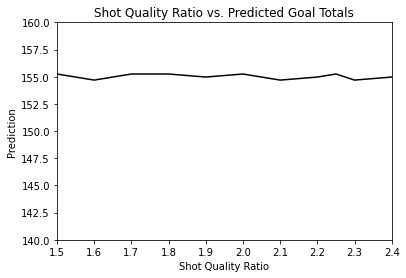

In [126]:
deepplot(index , 'sqr' , 'Shot Quality Ratio vs. Predicted Goal Totals')

#### Summary
- With the other maniuplated metrics, there was not a ton of impact made by shot quality ratio here.
- Keeping that in mind, that does send the message, that as long as the archers can maintain possession share and continue to score settled goals, they can improve their output drastically
- SQR of 2.0 provided one of the highest predictions, with no drastic improvement above or below it. 2.0 was attainable for the Archers with their current stats, so this is a realistic number as well

#### Wrapping Up

In [129]:
archers = team2022[team2022['Team'] == 'Archers']
v2archers = projectfinal(archers ,
        'Possession %' , .53 ,
        'Shot Quality Ratio', 2.0 ,
        'Settled Goal' , 8.3)

1/1 [==============================] - 0s 24ms/step


<ipython-input-127-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-127-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-127-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [154]:
print('Projected Goals per Game', v2archers['predictions'].mean())
print('Projected Total Goals' , v2archers['predictions'].sum())
print('Goals per Game',archers['Goals'].mean())
print('Total Goals',archers['Goals'].sum())
print('Goals per Game Delta', archers['Goals'].mean() - v2archers['predictions'].mean() )

Projected Goals per Game 12.701079368591309
Projected Total Goals 152.41295
Goals per Game 11.916666666666666
Total Goals 143
Goals per Game Delta -0.7844127019246425


In [156]:
team2022.groupby(['Team']).mean()[['Margin']]

,Margin
Team,
Archers,1.916667
Atlas,0.900000
Cannons,-2.700000
Chaos,-1.307692
Chrome,0.909091
Redwoods,-1.272727
Waterdogs,-0.250000
Whipsnakes,1.727273


#### Final Summary

Through attainable projected improvements to a few metrics, we were able to project the Archers scoring +0.78 goals per game. When looking at the average margins for each team it is easy to see how close these games are and those extra goals through the year can definitley add up. The continuation of this analysis would dive into the defensive benefits of these changes to see the full holistic impact we could see on the archers game. 


Final thoughts. With the archers keeping their shot quality ratio in the same bucket, scoring 0.50 more settled goals per game, and finding a way to achieve around 53% possession (for the year) , they can increase their yearly goal total by over 9 total goals. This league is dominated by tight margins and one goal games, finding an extra 9 goals through realistic level changes could prove beneficial to the team in the future and provide some insight into ways they can improve their already formidable offense next year. 

Points of focus for the Archers in 2023:
- Possession: whether it be faceoffs or slowing down pace of play, improving time on the ball will lead to more goals. They are on the lower end of the league in this currently. 

- Settled goals: Translate that increased possession into more settled goals, already a strong suite of the archers, combined with extra possessions can lead to a dangerous team. 2022 Champion Waterdogs dominated in this category.

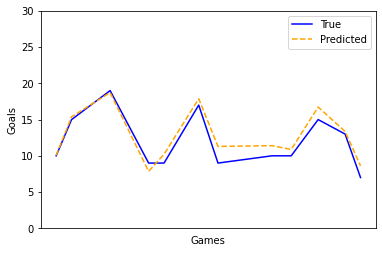

In [163]:
plotter(v2archers['predictions'] , archers['Goals'])